In [1]:
import pandas as pd
import numpy as np
import datetime

from matplotlib import pyplot as plt

## Wrangle Data

In [2]:
full_df = pd.read_csv('tracking.csv', parse_dates = ['date', 'last_seen'])
simple_df = full_df.copy()

In [3]:
# In the Python script, I used df.drop_duplicates(), but duplicates containing NaN values were not dropped
# even if they have duplciates.
# I will circumvent this issue by resetting NaN to a different "none"

cols = simple_df.columns

for col in cols:
    simple_df[col] = ['none' if each is np.nan else each for each in simple_df[col]]

In [4]:
simple_df.sort_values('last_seen', ascending = False, inplace = True)
simple_df.drop_duplicates(subset = ['name', 'price', 'location', 'images'], keep = 'first', inplace = True)

In [5]:
# drop all columns unnecessary for analysis
simple_df = simple_df.drop('url', axis = 1)

# only the number of images posted are in our interest
simple_df['images'] = simple_df['images'].apply(lambda x: 0 if (isinstance(x, float) and math.isnan(x)) else len(x.split(',')))

# only the number of characters of a listing's name is important for this analysis
simple_df['name'] = simple_df['name'].apply(lambda x: len(x))

simple_df.head()

,id,name,price,date,location,images,last_seen
21151,7164803513,19,995.0,2020-07-23 16:18:00,Bucket Of Nails,24,2020-08-22 18:00:18
21082,7166915620,48,899.0,2020-07-27 11:27:00,40-70% OFF RETAIL!,1,2020-08-22 18:00:18
21071,7167127774,55,280.0,2020-07-27 16:50:00,none,2,2020-08-22 18:00:18
21072,7178151570,18,75.0,2020-08-15 15:31:00,Scripps Ranch,4,2020-08-22 18:00:18
21073,7178051452,37,995.0,2020-08-15 12:44:00,Bucket of Nails,24,2020-08-22 18:00:18


## Important Constant Values

In [6]:
# When did the webscraping start and end?
start_date = simple_df['last_seen'].min()
end_date = simple_df['last_seen'].max()

# Over what course, in days, of time was data collected?
time_passed = (end_date - start_date).days + (end_date - start_date).seconds / 3600 / 24
time_passed

8.499849537037036

## For How Long Do Listings Usually Stay on The Website?

In [7]:
# Let's see for how long each listing was posted

# First, keep only the listings that are not available anymore

taken_down_df = simple_df[simple_df['last_seen'] < end_date]

# Then, keep only the latest post of each id:
# the dataframe records all changes made to every posting; 
# let's only observe the latest posting of each id

latest_taken_down_df = taken_down_df.sort_values('last_seen', ascending = False).groupby('id').first()

latest_taken_down_df.loc[:, 'duration'] = latest_taken_down_df.loc[:, 'last_seen'] - latest_taken_down_df.loc[:, 'date']

avg_duration = np.mean(latest_taken_down_df['duration'])
avg_duration = datetime.timedelta(days = avg_duration.days, seconds = int(avg_duration.seconds)) 

med_duration = np.median(latest_taken_down_df['duration']) / 10 ** 9
med_duration = datetime.timedelta(seconds = int(med_duration))

print('Average time a listing is posted: ', avg_duration)
print('Median time a listing is posted: ', med_duration)

Average time a listing is posted:  8 days, 13:54:20
Median time a listing is posted:  5 days, 12:12:18


Text(0.5, 1.0, 'How Long it Takes Until a Post Gets Taken Down')

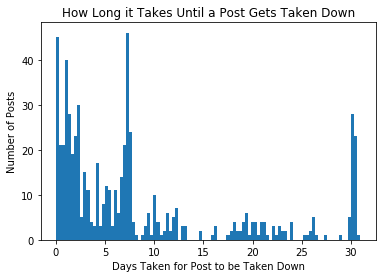

In [29]:
duration_hours = latest_taken_down_df['duration'].apply(lambda x: x.days + x.seconds / 3600 / 24)
ax = duration_hours.plot.hist(bins = 100)   # histogram showing how many days listings stayed on the webstie
ax.set_xlabel('Days Taken for Post to be Taken Down')
ax.set_ylabel('Number of Posts')
ax.set_title('How Long it Takes Until a Post Gets Taken Down')

## What Determines a Post's Duration, if any?

In [9]:
factor_df = latest_taken_down_df.drop(['date', 'last_seen'], axis = 1)
factor_df['duration'] = [each.days + int(each.seconds) / 3600 / 24 for each in factor_df['duration']]
factor_df

,name,price,location,images,duration
id,,,,,
7156614762,70,200.0,Mission Beach,11,7.223657
7158618437,65,25.0,"Each. San Marcos, Pioneer Industrial Park",9,7.632755
7159700475,29,219.0,SAN DIEGO,7,30.356424
7159799309,63,0.0,San Diego,24,30.384456
7159852995,54,1.0,none,24,30.416910
...,...,...,...,...,...
7182493857,63,60.0,Escondido,8,0.071586
7182500246,41,80.0,Encinitas,3,0.061863
7182506611,54,0.0,none,2,0.011169


/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'How May Characters There Are in a Product Title')

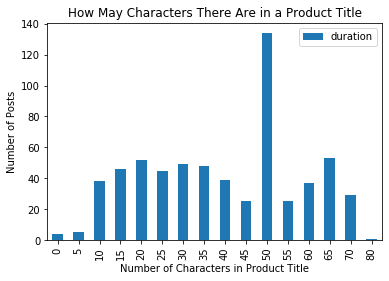

In [30]:
name_duration_df = factor_df[['name', 'duration']]
name_duration_df['name'] = name_duration_df['name'].apply(lambda x: x // 5)
name_duration_df['name'] = name_duration_df['name'] * 5
name_count = name_duration_df.groupby('name').count().reset_index().plot.bar(x = 'name', y = 'duration')
name_count.set_xlabel('Number of Characters in Product Title')
name_count.set_ylabel('Number of Posts')
name_count.set_title('How May Characters There Are in a Product Title')

Text(0.5, 1.0, 'Posting Duration VS Length of Product Title')

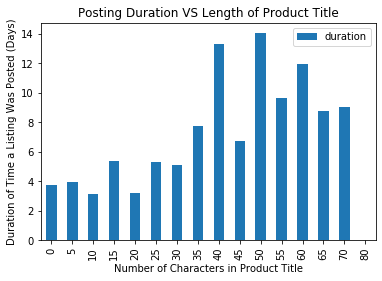

In [31]:
name_duration = name_duration_df.groupby('name').mean().reset_index()
name_duration = name_duration.plot.bar(x = 'name', y = 'duration')
name_duration.set_xlabel('Number of Characters in Product Title')
name_duration.set_ylabel('Duration of Time a Listing Was Posted (Days)')
name_duration.set_title('Posting Duration VS Length of Product Title')

/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'How Much a Product Costs')

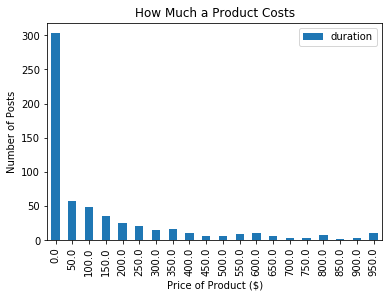

In [32]:
price_duration_df = factor_df[['price', 'duration']]
price_duration_df['price'] = price_duration_df['price'].apply(lambda x: x // 50)
price_duration_df['price'] = price_duration_df['price'] * 50
price_count = price_duration_df.groupby('price').count().reset_index().plot.bar(x = 'price', y = 'duration')
price_count.set_xlabel('Price of Product ($)')
price_count.set_ylabel('Number of Posts')
price_count.set_title('How Much a Product Costs')

Text(0.5, 1.0, 'Posting Duration VS Product Price')

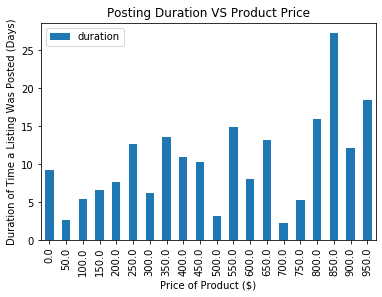

In [33]:
price_duration = price_duration_df.groupby('price').mean().reset_index()
price_duration = price_duration.plot.bar(x = 'price', y = 'duration')
price_duration.set_xlabel('Price of Product ($)')
price_duration.set_ylabel('Duration of Time a Listing Was Posted (Days)')
price_duration.set_title('Posting Duration VS Product Price')

/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'How Much a Product Costs (Under $50)')

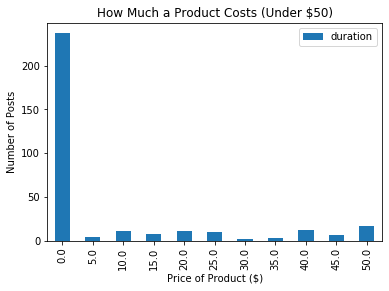

In [40]:
low_price_duration_df = factor_df[factor_df['price'] <= 50]
low_price_duration_df['price'] = low_price_duration_df['price'].apply(lambda x: x // 5)
low_price_duration_df['price'] = low_price_duration_df['price'] * 5
low_price_count = low_price_duration_df.groupby('price').count().reset_index().plot.bar(x = 'price', y = 'duration')

low_price_count.set_xlabel('Price of Product ($)')
low_price_count.set_ylabel('Number of Posts')
low_price_count.set_title('How Much a Product Costs (Under $50)')

Text(0.5, 1.0, 'Posting Duration VS Product Price (Under $50)')

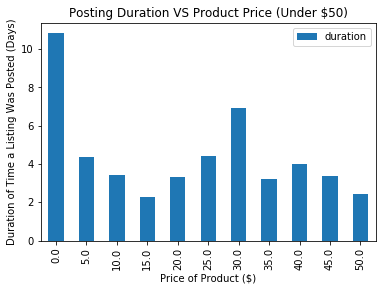

In [41]:
low_price_duration = low_price_duration_df.groupby('price').mean().reset_index()
low_price_duration = low_price_duration.plot.bar(x = 'price', y = 'duration')
low_price_duration.set_xlabel('Price of Product ($)')
low_price_duration.set_ylabel('Duration of Time a Listing Was Posted (Days)')
low_price_duration.set_title('Posting Duration VS Product Price (Under $50)')

/Users/taekunkim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'How Many Images a Listing Has')

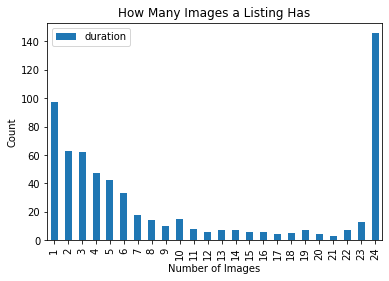

In [42]:
image_duration_df = factor_df[['images', 'duration']]
image_duration_df['images'] = image_duration_df['images']
image_count = image_duration_df.groupby('images').count().reset_index().plot.bar(x = 'images', y = 'duration')
image_count.set_xlabel('Number of Images')
image_count.set_ylabel('Count')
image_count.set_title('How Many Images a Listing Has')

Text(0.5, 1.0, 'Posting Duration VS Number of Images')

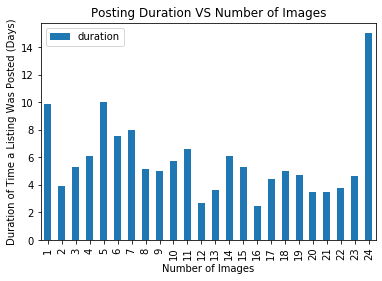

In [43]:
image_duration = image_duration_df.groupby('images').mean().reset_index()
image_duration = image_duration.plot.bar(x = 'images', y = 'duration')
image_duration.set_xlabel('Number of Images')
image_duration.set_ylabel('Duration of Time a Listing Was Posted (Days)')
image_duration.set_title('Posting Duration VS Number of Images')

## How Often Are Listings Posted?

In [18]:
# Number of posted after I started webscraping
posted_under_obs_df = simple_df[simple_df['date'] > start_date]
n_posted_under_obs = posted_under_obs_df['id'].nunique()

In [19]:
# Calculate average number of listings per day
avg_post_per_day = n_posted_under_obs / time_passed
print('On average, ', avg_post_per_day, ' listings are posted every day')

On average,  42.118392618605725  listings are posted every day


## How Often Are Changes Made to Posts?

In [20]:
# Find id of listings that were posted twice or more

repost_id = list(posted_under_obs_df.id)  # again, I only use listings that were first posted 
                                          # only after I started webscraping
repost_id = [each for each in repost_id if repost_id.count(each) > 1]
repost_id = list(set(repost_id))

In [44]:
# Find what percent of posts are every altered
repost_percent = len(repost_id) / n_posted_under_obs * 100
print('About ', round(repost_percent, 4), ' percent of posts were altered in some way after being posted')

About  9.2179  percent of posts were altered in some way after being posted


In [45]:
# Find how ofter those who make changes to their listings do so
reposts = simple_df[simple_df['id'].isin(repost_id)].sort_values('id')
n_changes = np.mean(reposts.groupby('id').count()['last_seen']) - 1

print('Those who make changes to their listings do so ', round(n_changes, 4), ', on average')

Those who make changes to their listings do so  1.2424 , on average


## What Part of a Post is Changed the Most?

In [23]:
cols = ['name', 'price', 'location', 'images']
changed = []

for each in repost_id:
    df = simple_df[simple_df['id'] == each]
    
    for i in range(len(df) - 1):
        
        for col in cols:
                        
            if any(df[col].ne(df[col].shift().bfill())):
                changed.append(col)
        

In [24]:
change_count = pd.DataFrame({'element': changed})
change_count['count'] = 1
change_count = change_count.groupby('element').count().reset_index().sort_values('count')

In [25]:
total_changes = sum(change_count['count'])
change_count['percentage'] = change_count['count'] / total_changes * 100

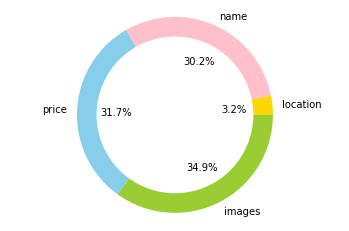

In [26]:
# The slices will be ordered and plotted counter-clockwise.
labels = change_count['element']
sizes = change_count['count']
colors = ['gold', 'pink', 'skyblue', 'yellowgreen']

plt.pie(sizes, labels = labels, colors = colors, autopct = '%1.1f%%')
        
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0), 0.8, fc = 'white', linewidth = 0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()  